# Advanced Lane Finding

The purpose of this code is to detect lanelines in the given video.


The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


We will start by importing all relevant libraries such as opencv, numpy required.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

## Read Pickle containing data saved from pipeline


There are two main steps to this process: use chessboard images to obtain image points and object points, and then use the OpenCV functions [**cv2.calibrateCamera()**](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) and [**cv2.undistort()**](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners) to compute the calibration and undistortion.

In [2]:
dist_pickle = pickle.load( open( "pickle/test_images_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

## Include relevant functions from the developed pipeline

We are including here only the relevant functions from our pipeline in the previous project. This will include the hue, saturation, x gradient and combined thresholding functions.

If we decide to change the image processing options and include other thresholds as well, we will enter them in the future in this box.

In [3]:
# Thresholding functions
# since we have evaludated earlier that HLS gives good image filtering results
# only included the relevant thresholding functions from "pipeline.ipynb"

def lightness_select(img, thresh = (120,255)):
    
    # 1. Convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2. Apply threshold to s channel
    l_channel = hls[:,:,1]
    # 3. Create empty array to store the binary output and apply threshold
    lightness_image = np.zeros_like(l_channel)
    lightness_image[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1

    return lightness_image

def saturation_select(img, thresh = (100,255)):

    # 1. convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2. apply threshold to s channel
    s_channel = hls[:,:,2]
    # 3. create empty array to store the binary output and apply threshold
    sat_image = np.zeros_like(s_channel)
    sat_image[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return sat_image


def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0,255)):

    # 1. Applying the Sobel depending on x or y direction and getting the absolute value
    if (orient == 'x'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if (orient == 'y'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 2. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 3. Create mask of '1's where the sobel magnitude is > thresh_min and < thresh_max
    sobel_image = np.zeros_like(scaled_sobel)
    sobel_image[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sobel_image


# More threhsolding functions can be added here from the pipeline for advacned filtering options

## Combined Thresholding

In the next step, we apply combined thresholding from our thresholding functions in the previous box. For details, refer to "pipeline.ipynb".


In [4]:
### Combined Thresholding Function
def combined_threshold(img):

    # convert to hls format and extract channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    # convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # applying thresholding and storing different filtered images
    l_binary = lightness_select(img, thresh = (120, 255))
    s_binary = saturation_select(img, thresh = (100, 255))

    ksize = 9
    gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))

    # creating an empty binary image
    combined_binary = np.zeros_like(s_binary)
    combined_binary[((gradx == 1) | (s_binary == 1)) & ((l_binary == 1) & (s_binary == 1))] = 1

    # apply region of interest mask
    height, width = combined_binary.shape
    mask = np.zeros_like(combined_binary)
    region = np.array([[0, height-1], [int(width/2), int(height/2)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region], 1)

    masked_binary = cv2.bitwise_and(combined_binary, mask)

    return masked_binary

## Perspective Transform

We apply the perspective transform using [**cv2.getPerspectiveTransform(src, dst)**](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#getperspectivetransform).

This function converts our camera view of the lanelines to a top-down view or a bird's eye view. We will use the image generated by this function for identifying lanelines and estimating the road curvatures.

In [5]:
# function for applying perspective view on the masked thresholded images
def perspective_view(img):
    img_size = (img.shape[1], img.shape[0])
    # image points extracted from image approximately
    bottom_left = [210, 720]
    bottom_right = [1100, 720]
    top_left = [575, 470]
    top_right = [720, 470]
    src = np.float32([bottom_left, bottom_right, top_right, top_left])
    pts = np.array([bottom_left, bottom_right, top_right, top_left])
    pts = pts.reshape((-1, 1, 2))
    # choose four points in warped image so that the lines should appear as parallel
    bottom_left_dst = [320, 720]
    bottom_right_dst = [920, 720]
    top_left_dst = [320, 1]
    top_right_dst = [920, 1]
    dst = np.float32([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])
    # apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # warp the image using perspective transform M
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

## Pipeline

Here we will work on developing a pipeline for processing individual images for detecting, visualizing lanelines and calculate the radius of curvature for lanelines.

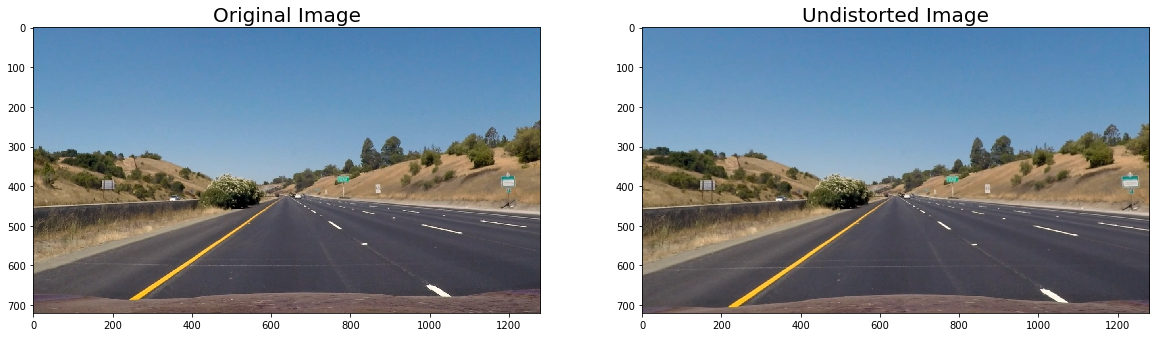

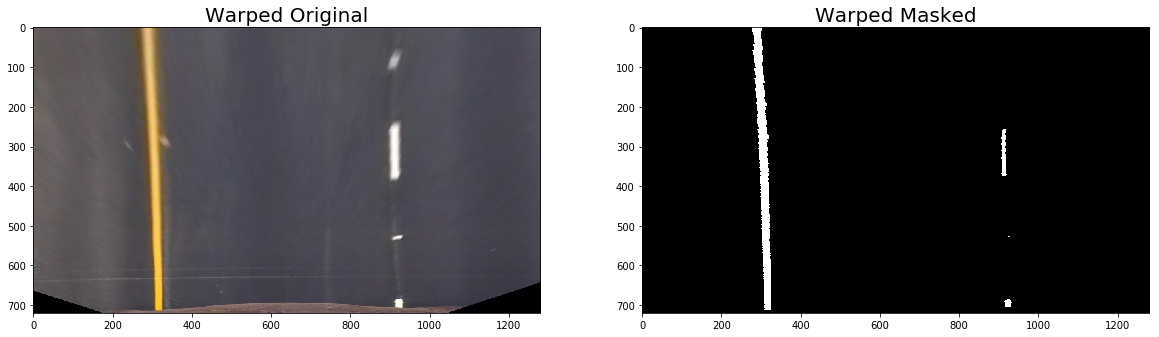

In [6]:
# read in an image
img = mpimg.imread("test_images/straight_lines1.jpg")

# undistort the original image using stored values from pickle
undist_original = cv2.undistort(img, mtx, dist, None, mtx)

# apply perspective view on the image
warped_original, M, Minv = perspective_view(undist_original)

# apply combined threshold
combined_threshold_img = combined_threshold(undist_original)

# apply perspective transform on the thresholded image
warped, M, Minv = perspective_view(combined_threshold_img)

plt.figure(1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_original)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

plt.figure(2)
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(warped_original)
ax3.set_title('Warped Original', fontsize=20)
ax4.imshow(warped, cmap = 'gray')
ax4.set_title('Warped Masked', fontsize=20)
plt.show()

### Pipeline

Here, we define a function which takes an image as input and executes a number of functions to give us a resulting image marking the lanelines and also calculations of **road curvature** and **vehicle center offset** values.

At the end of the function, I have commented out the part which plots all the different images (thresholded, original, warped and sliding boxes) for each frame. This is required when running the code on video stream instead of images. These images are not necessary to plot in every iteration even while running on images and hence they have been commented out.

In [7]:
# function to detect lanelines in images or video
def advanced_lanelines(img):

    # undistort the original image using stored values from pickle
    undist_original = cv2.undistort(img, mtx, dist, None, mtx)
    # apply perspective view on the image
    warped_original, M, Minv = perspective_view(undist_original)

    # apply combined threshold
    threshold = combined_threshold(img)
    # undistort the thresholded image
    undist_thresholded = cv2.undistort(threshold, mtx, dist, None, mtx)
    # apply perspective transform on the thresholded image
    warped, M, Minv = perspective_view(undist_thresholded)

    # these will be empty for the first iteration and they will store the values of lane fits from previous iterations
    # declaring lane fits as global variables so that they can be modified from anywhere in the code
    
    # list storing left and right lanefit values from previous frames
    global prev_left_fits
    global prev_right_fits

    # average of previous 10 lanefits
    global average_left_fit
    global average_right_fit

    # initialize the lanelines class by giving inputs from previous iteration
    binary_warped = LaneLines(warped, average_left_fit, average_right_fit)

    # calculate the left and right lane fits
    out_img, leftfit, rightfit = binary_warped.find_lane_pixels()

    # we convert our left and right fits from shape (3,) to an array of shape (1,3) to append it to our lists
    previous_left_fit_array = np.array([leftfit])
    previous_right_fit_array = np.array([rightfit])

    # we add fits from previous detections to our list of previous fits
    prev_left_fits = np.append(prev_left_fits, previous_left_fit_array, axis = 0)
    prev_right_fits = np.append(prev_right_fits, previous_right_fit_array, axis = 0)

    # we ensure that the list doesn't take into account more than 15 previous measurements
    # we delete the initial element of the array if it does, i.e. - earliest element in the array
    if (prev_left_fits.shape[0] > 15):
        prev_left_fits = np.delete(prev_left_fits, 0, axis = 0)
    if(prev_right_fits.shape[0] > 15):
        prev_right_fits = np.delete(prev_right_fits, 0, axis = 0)

    # compute average of past 10 best fits and pass them over to next iteration
    average_left_fit = np.mean(prev_left_fits, axis = 0)
    average_right_fit = np.mean(prev_right_fits, axis = 0)

    # get the left and right lane radii
    center_offset, left_radius, right_radius = binary_warped.measure_curvature()

    # calculation of road curvature
    road_radius = round(0.5*(left_radius+right_radius), 2)
    center_offset = round(center_offset, 2)
    road_curvature = "Road Curvature = " + str(road_radius) + "m"
    center_offset = "Center Offset = " + str(center_offset) + "m"

    # print("Left = ", left_radius)
    # print("Right = ", right_radius)
    # print("Road Curvature = ", road_radius)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([binary_warped.left_fitx, binary_warped.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([binary_warped.right_fitx, binary_warped.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undist_original, 1, unwarped, 0.3, 0)

    # this prints the value of road curvature onto the output image
    cv2.putText(result, road_curvature, (80, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

    # this prints the value of center offset onto the output image
    cv2.putText(result, center_offset, (80, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

    # VISUALIZATION
    # THIS SECTION SHOULD BE COMMENTED OUT WHEN RUNNING ON VIDEO STREAM
    
    '''
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(threshold, cmap = 'gray')
    ax2.set_title('Original Thresholded', fontsize=20)
    ax3.imshow(warped_original, cmap = 'gray')
    ax3.set_title('Warped Perspective', fontsize=20)
    ax4.imshow(out_img)
    ax4.set_title('Sliding Boxes', fontsize=20)
    plt.show()    
    '''

    return result

### Import necessary libraries (for video)

Here we import nencessary libraries for running our pipeline on video stream.

In [8]:
import moviepy
import imageio
from moviepy.editor import VideoFileClip

### Video Output

In [9]:
# define variables needed in the global scope
previous_left_fit = None
previous_right_fit = None

# initialize empty 1*3 empty arrays for calculating the storing lane fit data of previous frames
prev_left_fits = np.empty([1,3])
prev_right_fits = np.empty([1,3])

# intitialize the average left and right fit empty lists - these will be updated in every iteration
average_left_fit = []
average_right_fit = []

# import the lanelines class
from class_lanelines import LaneLines

# video pipeline
video_binary_output = 'videos_output/video-output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(advanced_lanelines) # NOTE: this function expects color images!!
white_clip.write_videofile(video_binary_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos_output/video-output.mp4.
Moviepy - Writing video videos_output/video-output.mp4



Moviepy - Done !
Moviepy - video ready videos_output/video-output.mp4
